In [1]:

import numpy as np
from scipy.fft import rfft
from matplotlib.pylab import *
from scipy.io import wavfile
from scipy.signal import stft
from IPython.display import Audio

import matplotlib.pyplot as plt
from scipy.sparse import linalg
import scipy
from numpy import *
import glob

**KNOWN CODES**

In [2]:
# Function to generate Audio spectogram
def generate_audio_spectogram(audio_data,dft_size,overlap,window):
  '''
  audio_data : Input  sound data
  dft_size   : len of your Fourier transform
  overlap    : overlap btw of 2 dfts
  window     : Hanning window

  Returns magnitudes of a sound spectogram
  '''

  audio_len = len(audio_data)
  hop_size = dft_size-overlap
  step_size = dft_size - hop_size
  num_window_frames = math.floor((audio_len - hop_size)/(hop_size))
  # Construct the Fourier Matrix
  dft_matrixs = []
  freqs = np.arange(0,dft_size,1)
  for n in range(dft_size):
      p = np.exp((-1j*2*np.pi*freqs*n)/dft_size)/np.sqrt(dft_size)
      dft_matrixs.append(p)
  F = np.array(dft_matrixs)

  # Applying Hanning window
  FH = np.multiply(F,window)

  # initilaize the output vector
  output = np.zeros((num_window_frames,dft_size),dtype=complex)

  # loop over all dft windows
  for sub_win_index in range(0,num_window_frames):
    temp_data = audio_data[sub_win_index*hop_size:(sub_win_index*hop_size+dft_size)]
    if len(temp_data) != dft_size:
      break
    # Generate DFT for each window upon multiplying audio data with Fourier matrix
    output[sub_win_index,:] = np.matmul(FH,temp_data)

  nyxt_output = (output.T)[:int(dft_size/2),:]

  # Take magnitufe of the spectogram
  nyxt_magnitudes = np.log(np.abs(nyxt_output))

  return nyxt_magnitudes

# Function to Normalize the data
def normalize_data(nyxt_magnitudes):
  '''
  nyxt_magnitudes : magnitudes of spectogram

  Returns Normalized spectogram
  '''
  mean_values = np.mean(nyxt_magnitudes,axis = 1)
  # broadcast/repeat the mean values along the axis
  mean_values = (np.ones((nyxt_magnitudes.shape[1],1))*mean_values).transpose()

  std_values = np.std(nyxt_magnitudes,axis = 1)
  # broadcast/repeat the std values along the axis
  std_values = (np.ones((nyxt_magnitudes.shape[1],1))*std_values).transpose()

  nyxt_magnitudes_norm = (nyxt_magnitudes - mean_values)
  return nyxt_magnitudes_norm

def load_audio_data(file_path,custom = False):
  # Given input data
  dft_size = 1024
  overlap = dft_size//2  # 1/2 of overlapp
  window = np.hamming(dft_size)
  data = []

  if custom:
    sample_rate, audio_data = wavfile.read(file_path)
    # Generate spectogram
    nyxt_magnitudes = generate_audio_spectogram(audio_data,dft_size,overlap,window)
    # Normalize spectogram
    nyxt_magnitudes_norm = normalize_data(nyxt_magnitudes)
    data.append(nyxt_magnitudes_norm)
    return data,sample_rate

  for file in [file_path+str(i)+".wav" for i in range(1,61)]:
    sample_rate, audio_data = wavfile.read(file)
    # Generate spectogram
    nyxt_magnitudes = generate_audio_spectogram(audio_data,dft_size,overlap,window)
    # Normalize spectogram
    nyxt_magnitudes_norm = normalize_data(nyxt_magnitudes)
    data.append(nyxt_magnitudes_norm)
  return data,sample_rate

def merge_data(train_x1,train_x2,test_x1,test_x2):
  train_x1_array = np.concatenate(list(train_x1),axis = 1)
  train_x2_array = np.concatenate(list(train_x2),axis = 1)
  test_x1_array = np.concatenate(list(test_x1),axis = 1)
  test_x2_array = np.concatenate(list(test_x2),axis = 1)

  train_x = np.concatenate([train_x1_array,train_x2_array],axis =1)
  train_y = np.concatenate([np.array([0 for i in range(train_x1_array.shape[1])]),np.array([1 for i in range(train_x2_array.shape[1])])])
  test_x = np.concatenate([test_x1_array,test_x2_array],axis =1)
  test_y = np.concatenate([np.array([0 for i in range(test_x1_array.shape[1])]),np.array([1 for i in range(test_x2_array.shape[1])])])

  return train_x,train_y,test_x,test_y


def discriminant(x, mean, cov):
    return -0.5 * np.dot(np.dot(( x - mean), np.linalg.inv(cov)), ( x - mean).T) - 0.5 * np.log(np.linalg.det(cov))

def get_mean_cov_per_class(num_classes,reduced_train,train_labels):

  class_means = []
  class_covariance = []

  for i in range(num_classes):
      class_data = reduced_train[train_labels == i]
      class_means.append(np.mean(class_data, axis=0))
      class_covariance.append((class_data.T @ class_data)/class_data.T.shape[1])

  return class_means,class_covariance

def get_gaussian_predictions(num_classes,reduced_test,test_labels,class_means,class_covariance):

  predictions = []
  for i in range(len(test_labels)):
      discriminants = []
      for j in range(num_classes):
          disc_value = discriminant(reduced_test[i], class_means[j], class_covariance[j])
          discriminants.append(disc_value)
      predicted_class = np.argmax(discriminants)
      predictions.append(predicted_class)
  return predictions

In [3]:
import glob
import scipy.io.wavfile
from random import shuffle
from numpy.fft import rfft

# Define spectrogram representation
def spectrogram_features(x, size):

    # Get frames
    lenl = len(x)//size
    # print("no of values : ",len(x))
    # print("no of frames : ",lenl)
    x = reshape(x[:lenl*size], (lenl,-1)).T
    # print("x shape : ",x.shape)
    # Window and FFT them
    w = hanning(size)[:,None]
    FFT = rfft(w*x, axis=0)
    # print("fft shape : ",FFT.shape)
    # Return log magnitude
    return log(abs(FFT) + 1e-8)


#using the same PCA function from my last assignment
def pca(data, num_eigen):

    mean = np.mean(data, axis=1, keepdims=True)

    # Remove mean from data before performing PCA
    mean_removed_data = data - mean

    # Get covariance estimate C(Z) = (Z.ZT) /n-1
    C = np.dot(mean_removed_data, np.transpose(mean_removed_data)) / (mean_removed_data.shape[1]-1)

    # Get top 3/k PCA covariance eigenvectors/values
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(C, k=num_eigen)

    #descending order of eigenvalues and vectors
    eigenvalues = eigenvalues[::-1]
    eigenvectors = eigenvectors[:,::-1]

    # Resulting transformation
    pcas = np.dot(diag(1.0/sqrt(eigenvalues)), np.transpose(eigenvectors))

    return pcas, mean


# gaussian_classifier for each class
def gaussian_classifier(x, gauss=None, diagonal=False):

    # If no model is provided, then train
    if gauss is None:

        # class mean
        mean = np.mean(x, axis=1, keepdims=True)
        # print("mean shape ", mean.shape )
        # class covariance
        covariance = ((x-mean) @ (x-mean).T) / (x.shape[1]-1)

        if diagonal:
            covariance = np.diag(np.diag(covariance))

        return {"mean": mean, "icov": np.linalg.inv(covariance)}

    # If a model is provided just compute log likelihoods
    else:
        mean = gauss["mean"]
        cov = gauss["icov"]
        # print("mean shape ", mean.shape )
        # print("cov shape ", cov.shape )
        # print("x shape ", x.shape )
        x_m = x - mean
        delta = sum(x_m * (cov @ x_m), axis=0)

        # Compute class likelihood P(x|ωi)
        return -.5*(-np.log(np.linalg.det(cov)) + delta + x.shape[0] * np.log(2 * np.pi))

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [5]:
from tqdm import tqdm

In [6]:
directory = "/content/drive/MyDrive/cs545/FinalProject/"


In [10]:
genres_all_train_test_data = {
              "pop" : {},
              "blues" : {},
              "classical" : {},
              "country" : {},
              "disco" : {},
              "hiphop" : {},
              "jazz" : {},
              "metal" : {},
              "reggae" : {},
              "rock" : {}
              }

audio = directory+'Data/genres_original/'
print(audio)
def read_data_by_class(target_class):
  size = 21844
  music = []
  for i in glob.glob(audio+ target_class+ '/' + target_class + '.*.wav'):
    try:
      file = scipy.io.wavfile.read(i)[1]
      # print(file.shape)
      log_mag = spectrogram_features(file, size)
      # print(log_mag.shape)
      music.append(log_mag)

    except Exception as e:
      print(e)

  return music


# value = read_data_by_class('pop')

/content/drive/MyDrive/cs545/FinalProject/Data/genres_original/


In [11]:
all_genres_train = []
all_genres_test = []

for key,_ in tqdm(genres_all_train_test_data.items()):

  value = read_data_by_class(key)
  # break
  # print("key", key)
  # print("value", len(value))
  genres_all_train_test_data[key]["all"] = value
  i = int(0.9 * len(value))
  train_value = np.hstack(value[:i])
  test_value = np.hstack(value[i:])
  genres_all_train_test_data[key]["train"] = train_value
  genres_all_train_test_data[key]["test"] = test_value
  all_genres_train.append(train_value)
  all_genres_test.append(test_value)

 60%|██████    | 6/10 [00:42<00:27,  6.80s/it]

File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported.


100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


In [12]:
all_genres_test[0].shape

(10923, 300)

In [13]:
print("len of all_genres_train ",len(all_genres_train))
print("len of all_genres_test ",len(all_genres_test))

all_genres_train = tuple(all_genres_train)
all_genres_test = tuple(all_genres_test)

all_train_data = np.hstack(all_genres_train)
print(all_train_data.shape)

all_test_data = np.hstack(all_genres_test)
print(all_test_data.shape)

len of all_genres_train  10
len of all_genres_test  10
(10923, 26970)
(10923, 3000)


In [49]:
# PCA
wt, mean = pca(all_train_data, 90)


# Create test data
test_combined = wt @ (all_test_data - mean)


likelihoods = []
test_data_labels = []
i = 0
for key, value in genres_all_train_test_data.items():
  test_data_labels = test_data_labels + [i for x in range(genres_all_train_test_data[key]["test"].shape[1])]

  # Create gaussian models using the gaussian_classifier created above
  g_music = gaussian_classifier(wt @ (value["train"] - mean))
  genres_all_train_test_data[key]["g_class"] = g_music

  # Evaluate gaussian model on test data
  output = gaussian_classifier(test_combined, g_music)
  likelihoods.append(output)
  i+=1

# Pick the class with the highest likelihood
classs = argmax(likelihoods, axis=0)

In [50]:
print(all_train_data.shape)

(10923, 26970)


In [51]:
print(classs.shape, all_test_data.shape)
print(len(test_data_labels))

(3000,) (10923, 3000)
3000


Frame-level Accuracy 59.63333333333333


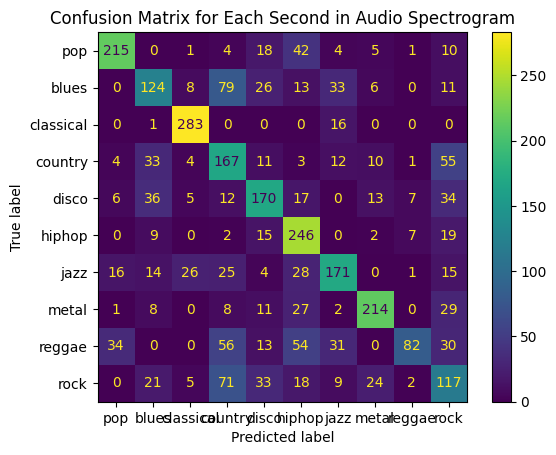

In [52]:
#pca = 100
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix using testing data
conf_mat = confusion_matrix(test_data_labels, classs)

#frame-level accuracy
print("Frame-level Accuracy", 100*trace(conf_mat)/len(test_data_labels))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=list(genres_all_train_test_data.keys()))
disp.plot()
plt.title("Confusion Matrix for Each Second in Audio Spectrogram")
plt.show()

Frame-level Accuracy 79.0


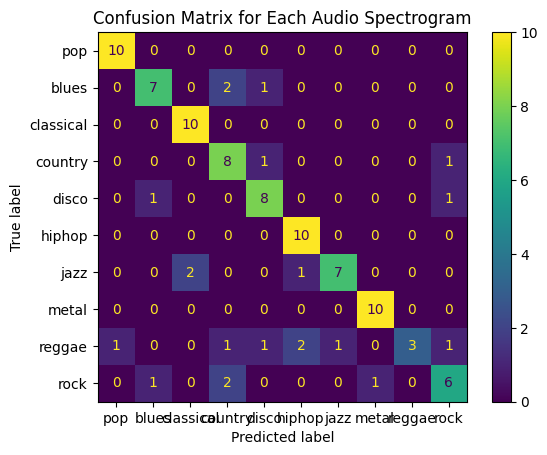

In [53]:
from statistics import mode

test_data_labels_by_audio = []
classs_by_audio = []
for i in range(0,3000,30):
  curr_predicted_list = classs[i:i+30]
  curr_target_list = test_data_labels[i:i+30]
  mode_predicted = mode(curr_predicted_list)
  mode_target = mode(curr_target_list)
  # print("curr_predicted_list", len(curr_predicted_list),curr_predicted_list, mode_predicted)
  # print("curr_target_list", len(curr_target_list),curr_target_list, mode_target)
  test_data_labels_by_audio.append(mode_target)
  classs_by_audio.append(mode_predicted)
  # break


#pca = 100
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix using testing data
conf_mat2 = confusion_matrix(test_data_labels_by_audio, classs_by_audio)

#frame-level accuracy
print("Frame-level Accuracy", 100*trace(conf_mat2)/len(test_data_labels_by_audio))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat2, display_labels=list(genres_all_train_test_data.keys()))
disp.plot()
plt.title("Confusion Matrix for Each Audio Spectrogram")
plt.show()

In [ ]:
one_sample  = all_train_data[0]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

history = {}
for num_eigen in range(0, 122, 20):
    if num_eigen==0:
        num_eigen = 1
    print("num_eigen : ",num_eigen)
    # Perform dimensionality reduction with PCA
    wt, mean = pca(all_train_data, num_eigen)

    # Get low-dimensional versions of both training and validation data
    test_combined = wt @ (all_test_data - mean)

    likelihoods = []
    test_data_labels = []
    i = 0
    for key, value in genres_all_train_test_data.items():
      test_data_labels = test_data_labels + [i for x in range(genres_all_train_test_data[key]["test"].shape[1])]

      # Create gaussian models using the gaussian_classifier created above
      gauss = gaussian_classifier(wt @ (value["train"] - mean))
      genres_all_train_test_data[key]["g_class"] = gauss

      # Evaluate gaussian model on test data
      output = gaussian_classifier(test_combined, gauss)
      likelihoods.append(output)
      i+=1

    # Pick the class with the highest likelihood
    classs = argmax(likelihoods, axis=0)

    # Compute confusion matrix using testing data
    conf_mat = confusion_matrix(test_data_labels, classs, labels=test_data_labels)

    # save results to plot later
    history[num_eigen] = [conf_mat, 100*trace(conf_mat)/len(test_data_labels)]
    print("accuracy : ",100*trace(conf_mat)/len(test_data_labels))
    # break

num_eigen :  1


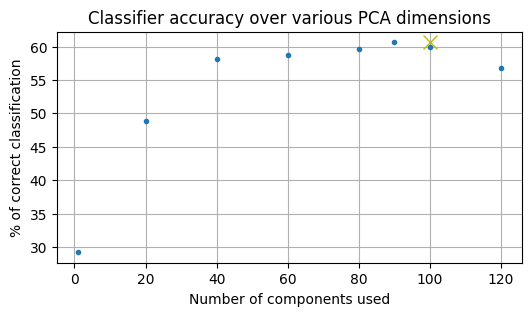

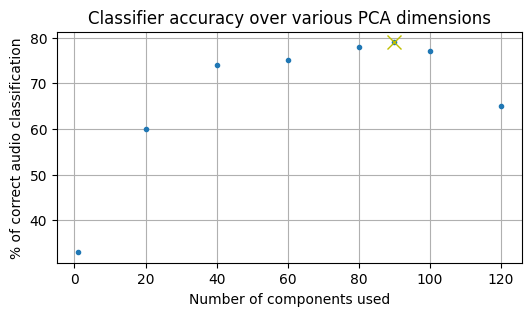

In [56]:
# print(history)
# max_acc = amax([v[1] for k,v in history.items()])
# for k,v in history.items():
#     if v[1]==max_acc:
#         max_acc_num_eigen = k
#         max_acc_conf_mat = v[0]
#         maxx_acc = v[1]
#         break

# print("max_acc_num_eigen ", max_acc_num_eigen)
# print("maxx_acc", maxx_acc)
# print("max_acc_conf_mat ",max_acc_conf_mat)

import matplotlib.pyplot as plt
from matplotlib.pylab import *

# plotting for stft of size 21624
plt.figure(figsize = (6, 3))
# plt.plot([k for k in history.keys()], [acc[1] for acc in history.values()], '.')
plt.plot([1,20,40,60,80,90, 100,120], [29.2, 48.8, 58.13, 58.73, 59.63, 60.66, 60.0, 56.77], '.')
plt.plot(100, 60.66, 'yx', markersize=10), grid('on')
xlabel('Number of components used'), ylabel('% of correct classification')
title('Classifier accuracy over various PCA dimensions')
plt.show()


# plotting for stft of size 21624 for each audio
plt.figure(figsize = (6, 3))
# plt.plot([k for k in history.keys()], [acc[1] for acc in history.values()], '.')
plt.plot([1,20,40,60,80,90,100,120], [33, 60, 74, 75, 78, 79, 77.0, 65], '.')
plt.plot(90, 79, 'yx', markersize=10), grid('on')
xlabel('Number of components used'), ylabel('% of correct audio classification')
title('Classifier accuracy over various PCA dimensions')
plt.show()

In [ ]:
for i in range(0, 122, 20):
  print(i)

0
20
40
60
80
100
120


Frame-level Accuracy 42.09907120743034


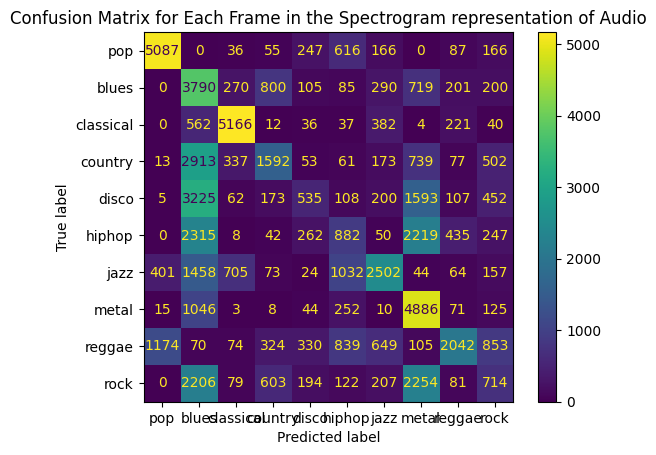

In [ ]:
#pca = 30
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix using testing data
conf_mat = confusion_matrix(test_data_labels, classs)

#frame-level accuracy
print("Frame-level Accuracy", 100*trace(conf_mat)/len(test_data_labels))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=list(genres_all_train_test_data.keys()))
disp.plot()
plt.title("Confusion Matrix for Each Frame in the Spectrogram representation of Audio")
plt.show()

In [ ]:
#pca = 30
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix using testing data
conf_mat = confusion_matrix(test_data_labels, classs)

#frame-level accuracy
print("Frame-level Accuracy", 100*trace(conf_mat)/len(test_data_labels))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=list(genres_all_train_test_data.keys()))
disp.plot()
plt.title("Confusion Matrix for Each Frame in the Spectrogram representation of Audio")
plt.show()

ValueError: ignored

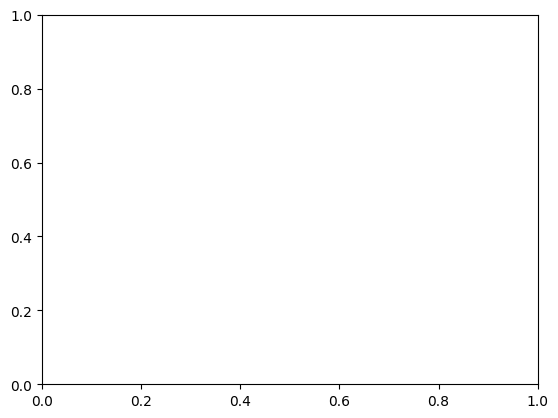

In [ ]:
import matplotlib.pyplot as plt
plt.pcolormesh(all_genres_train[1])

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=10)

In [ ]:
#Plot the training and validation accuracy.

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(test_features)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['background', 'chainsaw', 'engine', 'storm']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')